# Problem statement

\
The aim is to identify patterns which indicate if a person is likely to default, which may be used for taking actions such as denying the loan, reducing the amount of loan, lending (to risky applicants) at a higher interest rate, etc.

# Load Dataset

In [1]:
# Load Libraries
import pandas as pd
import numpy as np
import matplotlib as plt
import seaborn as sns
import matplotlib.pyplot as pyplot

In [2]:
loan = pd.read_csv("C:/Users/Personal/Documents/AIML_Notebooks/Lending_Club/loan.csv",low_memory = False)

In [3]:
meta = pd.read_excel("C:/Users/Personal/Documents/AIML_Notebooks/Lending_Club/Data_Dictionary.xlsx",header = 0)
# data dictionary read as meta data

In [4]:
# Define functions

## pct_to_float ###
def pct_to_float(DF,Col):
    '''
    This function changes data in str (%) format to float
    '''
    res = [float(DF[Col].astype(str).iloc[x].replace("%",""))/100 for x in range(len(DF[Col]))]
    return res


def plots(list,name = "number",title = "plot",long = False):
    '''
    this function creates sub-plots based on the variable and plot needed
    args: name is chosen based on the variable type: "number" for continuous variable and 
    "count" for categorical variable
    '''
    if len(list) % 3 == 0: 
        n = (len(list)//3)
    else:
        n = (len(list)//3) + 1
    fig, axes = pyplot.subplots(n, 3, figsize=(15, 5*n))        
    fig.suptitle(title)
    if name == "number":
        for i in range(len(list)):
            pyplot.subplot(n,3,i+1)
            sns.distplot(loan[list[i]],bins = 5)
            pyplot.title(list[i])
       
    if name == "count":
        for i in range(len(list)):
            pyplot.subplot(n,3,i+1)
            sns.countplot(loan[list[i]])
            pyplot.title(list[i])
            


            
def univar(Var,Bins = 5, Plot = "dist"):
    '''
    This function generates plots based on variable for univariate analysis
    '''
    if Var in meta['LoanStatNew']:
        type = meta[meta["LoanStatNew"] == Var].dtype
    else:
        type = loan[Var].dtype ## For derived variables
        
    if (np.logical_and(np.logical_or(type == "int64",type == "loat64"),Plot == "dist")).any():
        plot = sns.distplot(loan[Var], bins= Bins)
        return plot
      
    elif type == "object":
        plot = sns.histplot(loan[Var], bins= Bins)
        return plot
    elif (np.logical_and(np.logical_or(type == "int64",type == "loat64"),Plot == "box")).any():
        plot = sns.box(loan[Var], orient = "h")
        return plot
    elif Plot == "count":
        plot = sns.countplot(loan.addr_state)
        return plot
   
           

## Basic sanity check

*  **Objective**: In the data, the customers and loans are identified by the columns "member_id" and "id" respectively. We need to identify if there are any duplicates. 
* **Test**: we check if the number of values equal the rows in the dataframe. We observe that there are no duplicate rows.
* **Observation**: We observe that there are no duplicate rows.

In [5]:
print(loan.shape) # check no. of rows and columns
print(loan.member_id.nunique() == len(loan)) # True, no duplicates
print(loan.id.nunique() == len(loan)) #  True, no duplicates

(39717, 111)
True
True


## Data Filtering: Current Loans

* **Objective**:As this analysis identifies the driving factors of default, we need to have the final status for each loan. 
* **Operation**: The loans (rows) with "Current" status can be filtered out before starting the column operations.

In [6]:
loan = loan[loan["loan_status"] != 'Current']
print(loan.shape) # Loans with Current status are removed

(38577, 111)


# Data Cleaning

**Objective**: Data needs to be cleaned for missing values, formats and any other abnormal value in a series of steps in the data cleaning procedure.

**Step 1**:  Select columns which have meaningful information by removing columns of data which do not have any information

In [7]:
loan = loan.loc[:,[x for x in loan.columns.tolist() if  loan[x].isna().sum() != len(loan)]]
print(loan.shape) # Only 56 columns remain. Hence, 55 columns had no information

(38577, 56)


**Step2**: Next, we look at columns with very high number (> 90\% of missing values).

In [8]:
loan.isnull().sum()[loan.columns[loan.isnull().sum()/len(loan) > 0.9]] # only mths_since_last_record has more than 90% missing values

mths_since_last_record    35837
dtype: int64

* A public record can be a law suit, bankruptacy, foreclosure or a tax lien. Hence, having a public record may not be a good indicator for credit worthiness. Months since last record may indicate improvong financial health. However, there are too many missing values. Hence, removing the column "mths_since_last_record". 

In [9]:
loan = loan.drop("mths_since_last_record",axis = 1)
print(loan.shape) # 55 columns remain

(38577, 55)


**Step3**: Remove columns with same values for all rows as they will not help in differentiating the loan status


In [10]:
idx2 = list(np.where([(loan[x].nunique() == 1) & (loan[x].isnull().sum()==0) for x in loan.columns.values.tolist()]))
loan = loan.drop(loan.iloc[:,idx2[0]].columns,axis=1)
loan.shape # 8 more columns removed

(38577, 47)

* ID and member Id variables may be removed.

In [11]:
loan = loan.drop(["id","member_id"],axis = 1)
loan.shape

(38577, 45)

**Step 4**: Correct the formats by checking for any incorrect values. To fill, we need to know the datatypes for each column

In [12]:
# Using meta data file to store formats and Reset order according loan columns in meta data
meta = meta.iloc[meta.reset_index().set_index("LoanStatNew").loc[loan.columns.values, 'index'].values,:]
meta['dtype'] = loan.dtypes.astype(str).tolist()
objtype = meta[meta["dtype"] == "object"]


In [13]:
## Converting revol_util and int_rate
loan["revol_util"] = pct_to_float(DF=loan,Col= "revol_util")
loan["int_rate"] = pct_to_float(DF=loan,Col = "int_rate")


In [14]:
# Date format
date_cols = ["issue_d","earliest_cr_line","last_pymnt_d","last_credit_pull_d"] # Columns which are dates

## change to pandas date format
for y in date_cols:
    loan[y] = pd.to_datetime(loan[y].astype(str),format = "%b-%y")

**Special Case**: As it is mentioned in the data dictionary that Employer title replaces Employer Name after 9/23/2013, the variable emp_title is examined. Based on the below data points,  the information is considered redundant.

In [15]:
loan[loan["issue_d"] < "2013-09-23"].shape [0] == loan.shape[0] # This indicates there are no loans issued after the set date 

True

**Step 6 -  Outlier Treatment** :

* **Objective**: Any outliers in the outlier data should be treated. 
* **Test**: Check visually through box plots which present the outliers beyond the +/- 1.5 * IQR
* **Observation**: Outliers are mostly present in annaul income and revolving balance. 
* **Reecommendation**: Removing data points is not recommended. However, the alternatives to annual income and revovling balance,  attributes DTI ratio (dti) and revolving  utilization rate (revol_util) do not have outliers as the ratio is balances out the outliers. Hence, for the analysis purpose, we will consider dti and revol_util.

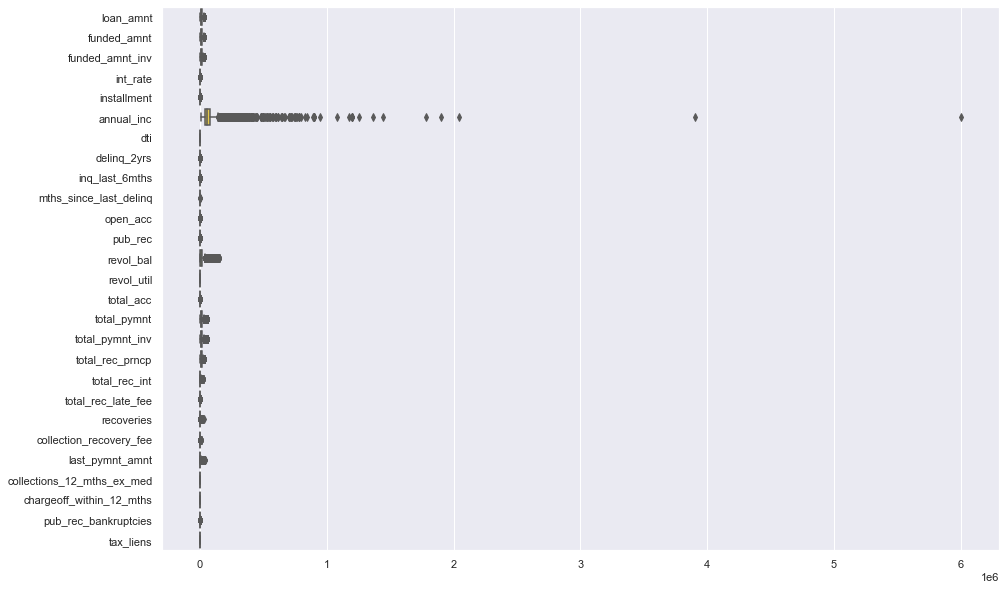

In [16]:
sns.set(rc={'figure.figsize':(15, 10)})
sns.boxplot(data = loan,orient = "h", palette="Set2")
pyplot.show()

* **Step 7**: Data Sanity Check #2

**Objective** : Change the format where required such that data is coherent

In [17]:
loan.describe() # checking for format across numeric columns

,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,...,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,collections_12_mths_ex_med,chargeoff_within_12_mths,pub_rec_bankruptcies,tax_liens
count,38577.000000,38577.000000,38577.000000,38577.000000,38577.000000,3.857700e+04,38577.000000,38577.000000,38577.000000,13672.000000,...,38577.000000,38577.000000,38577.000000,38577.000000,38577.000000,38577.000000,38521.0,38521.0,37880.000000,38538.0
mean,11047.025430,10784.058506,10222.481123,0.119322,322.466318,6.877797e+04,13.272727,0.146668,0.871737,35.882534,...,9648.322898,2119.243370,1.368634,98.035545,12.772728,2746.243218,0.0,0.0,0.043479,0.0
std,7348.441646,7090.306027,7022.720644,0.036913,208.639215,6.421868e+04,6.673044,0.492271,1.071546,22.028093,...,7009.381200,2389.499511,7.315880,698.650182,150.836853,4494.648131,0.0,0.0,0.204583,0.0
min,500.000000,500.000000,0.000000,0.054200,15.690000,4.000000e+03,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0
25%,5300.000000,5200.000000,5000.000000,0.089400,165.740000,4.000000e+04,8.130000,0.000000,0.000000,18.000000,...,4500.000000,643.990000,0.000000,0.000000,0.000000,217.420000,0.0,0.0,0.000000,0.0
50%,9600.000000,9550.000000,8733.440000,0.117100,277.860000,5.886800e+04,13.370000,0.000000,1.000000,34.000000,...,8000.000000,1300.450000,0.000000,0.000000,0.000000,568.260000,0.0,0.0,0.000000,0.0
75%,15000.000000,15000.000000,14000.000000,0.143800,425.550000,8.200000e+04,18.560000,0.000000,1.000000,52.000000,...,13175.000000,2671.980000,0.000000,0.000000,0.000000,3447.250000,0.0,0.0,0.000000,0.0
max,35000.000000,35000.000000,35000.000000,0.244000,1305.190000,6.000000e+06,29.990000,11.000000,8.000000,120.000000,...,35000.020000,23563.680000,180.200000,29623.350000,7002.190000,36115.200000,0.0,0.0,2.000000,0.0


In [18]:
loan["annual_inc"] = loan["annual_inc"].apply(lambda x: float(format(x, '.2f')))
# Suppressing scientific format to float decimal

In [19]:
loan['dti'] = loan['dti']/100
# converting to ratio

* **Step 8**: Data filling & Variable Creation

In [20]:

### Identify the columns which have missing values
nullvalues_pct = (loan.isnull().sum()/len(loan))*100
nullvalues_pct = nullvalues_pct[nullvalues_pct !=0]
nullvalues_pct.sort_values(ascending=False)


mths_since_last_delinq        64.559193
desc                          32.472717
emp_title                      6.185033
emp_length                     2.677761
pub_rec_bankruptcies           1.806776
last_pymnt_d                   0.184047
collections_12_mths_ex_med     0.145164
chargeoff_within_12_mths       0.145164
revol_util                     0.129611
tax_liens                      0.101097
title                          0.028514
last_credit_pull_d             0.005184
dtype: float64

* **next_pymnt_d and mths_since_last_delinq**: With more than 64\% missing values, "mths_since_last_delinq" has too many missing values, hence removing. 

In [21]:
loan = loan.drop("mths_since_last_delinq",axis = 1)

* **desc and emp_title**: As these are individual-specific, fill with "Not known". The logic behind reducing them to 2 categories is two-fold:
1. Any borrower who has not provided certain information may act as an early warning indicator or lack of due process.
2. 2 categories can converted to one-hot encoding for ease of data handling. 

In [22]:
loan["desc"].fillna("Not Known",inplace = True)
loan.desc = loan.desc.apply(lambda x: "Not Known" if x == "Not Known" else "Known")


* **emp_length, pub_rec_bankruptcies and title**: As the percent of missing values is low, mode can be used to fill these columns

In [23]:
mode_cols = ['emp_length', 'pub_rec_bankruptcies','title']
loan['emp_length'].fillna(loan['emp_length'].mode()[0],inplace = True)
loan['pub_rec_bankruptcies'].fillna(loan['pub_rec_bankruptcies'].mode()[0],inplace = True)
loan['title'].fillna(loan['title'].mode()[0],inplace = True)

* **revol_util**: As the missing value number is low, fill by median

In [24]:
loan['revol_util'].median() # not affected by outliers

0.491

In [25]:
loan['revol_util'].fillna(loan['revol_util'].median(),inplace = True)

* **last_credit_pull_d**: Fill with the issue_d, assuming that the current loan is the last credit pulled

In [26]:
loan['last_credit_pull_d'].fillna(loan['issue_d'],inplace = True)

* **last_pymnt_d**: The median difference of issue date and last payment date where both are available will be taken as the basis for creation of last payment date where missing.

In [27]:
df = loan[~loan['last_pymnt_d'].isnull()]

In [28]:
fill = round(np.median((df.issue_d - df.last_pymnt_d)/np.timedelta64(1, 'M')))

In [29]:
from pandas.tseries.offsets import DateOffset

loan['last_pymnt_d'].fillna(loan.issue_d + DateOffset(months=fill),inplace = True)

In [30]:
loan.last_pymnt_d.isnull().sum() # check

0

* **collections_12_mths_ex_med, chargeoff_within_12_mths and tax_liens**: These variables have value of wither 0 or NA, which do not add value to the analysis, Hence, removing these variables from the analysis.

In [31]:
loan = loan.drop(['collections_12_mths_ex_med', 'chargeoff_within_12_mths', 'tax_liens'], axis = 1)

* **Step8**: Selection of variables

*  Some columns like url, identifiers and recovery/ payment collection data fields can be eliminated as they do not impact the chances of default.

In [32]:
loan = loan.drop(['url','emp_title','title','total_pymnt_inv', 'total_rec_prncp','total_rec_int', 'total_rec_late_fee','last_pymnt_amnt','last_pymnt_d','total_pymnt', "recoveries", "collection_recovery_fee"], axis = 1)

## Univariate Analysis

**Objective**: The objective of this analyze numerical and categorical variables to:
1. Assess distribution of variables
2. Identify any patterns in variables like skewness, seasonality, etc
3. Understand characterstics of portfolio through geography, term, purpose, grade and other characterstics


### Target Variable Distribution

As our target is to identify the risky customers,i.e., those who are more likely to default, the target variable is status of loan. It is indicated by the column "loan_status". Based on the below plot, there are more number of Fully Paid loans than charged off loans. 

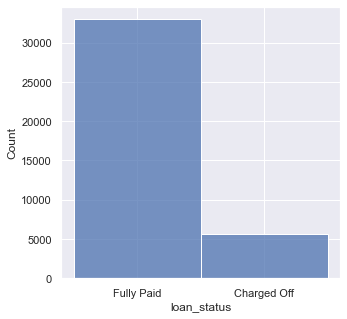

In [33]:
sns.set(rc={'figure.figsize':(5, 5)})
univar(Var = "loan_status")
pyplot.show() # Observation: Most loans are fully paid

In [34]:
100 * loan.loan_status.value_counts()/len(loan) # approx 85% fully paid and 15% default

Fully Paid     85.413588
Charged Off    14.586412
Name: loan_status, dtype: float64

### Subplot creation for each group of variables

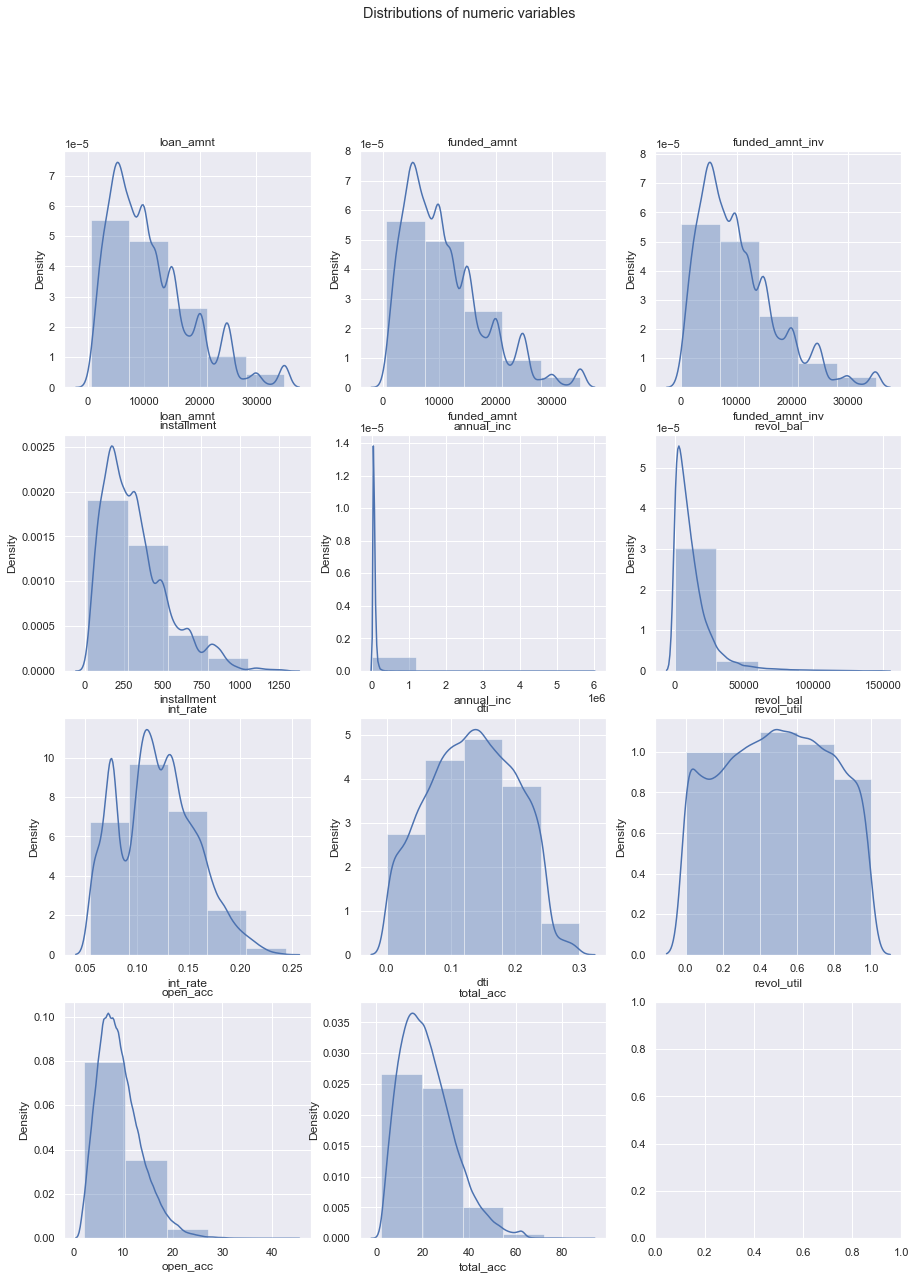

In [35]:
import warnings
warnings.filterwarnings('ignore')
numeric = ["loan_amnt","funded_amnt","funded_amnt_inv","installment", "annual_inc","revol_bal","int_rate","dti",'revol_util','open_acc','total_acc']
plots(numeric, title = "Distributions of numeric variables")


*Observations*: 
- Loan amount, Funded amount and funded amount by investor columns have common distribution because of similar values in most. We are going to consider "loan_amnt" as our goal is to assess default risk at the time of application.
- Installment follows similar distribution to loan amount.
- Presence of outliers in annual income column (as seen in outlier analysis) has made the distribution skewed
- revol_balance is skewed in distribution 
- Most number of loans have interest rate between 10% to 15%, but loans are evenly distributed across the rates
- dti is expressed in percentage terms, but it is clear that majority of loans have dti less than 20%
- revolving utilization rate is evenly distributed. Needs segmented analysis.
- Customers tend to have large number of total and open accounts. May need segmented analysis.

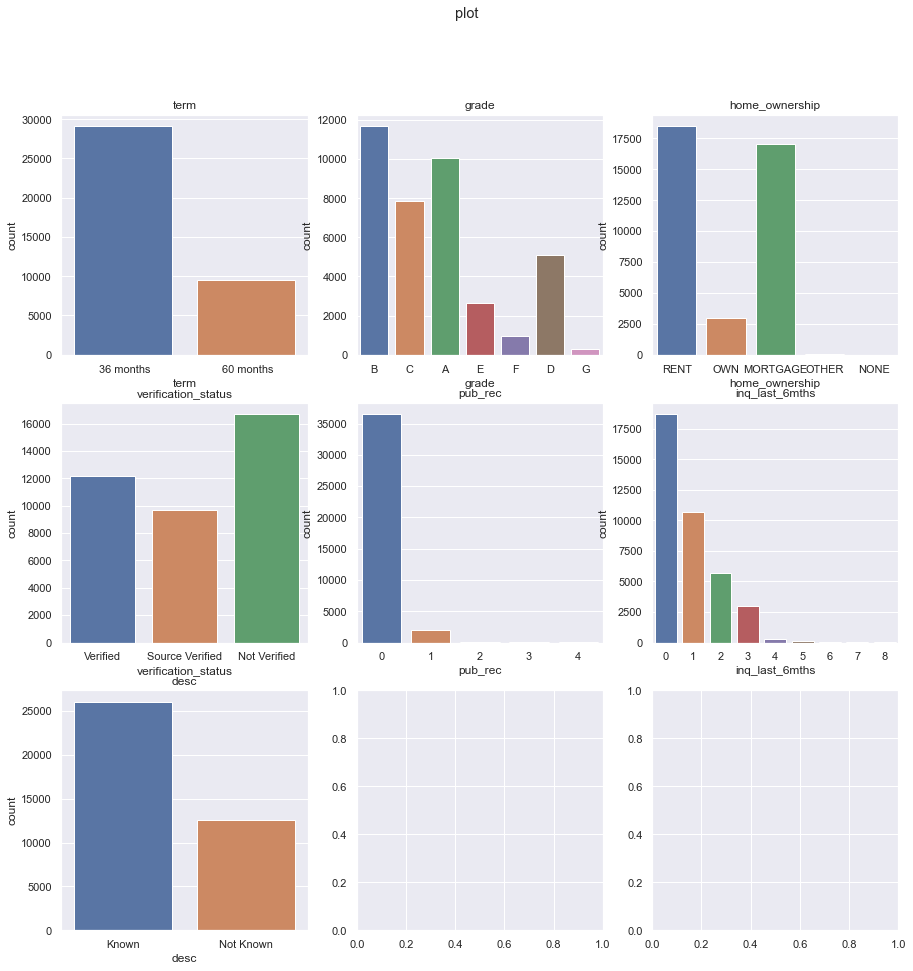

In [36]:
count = ['term','grade','home_ownership','verification_status','pub_rec','inq_last_6mths','desc']
plots(list = count,name = "count",long = 1)


*Observarions*:
- Most loans are of 36 months term
- Most loans are from grade A and B, meaning less risky
- A large proportion of borrowers do not have own house or have mortgage
- A large proprtion of loans have not verified status
- Most borrowers do not have public record on bankruptacy or others
- Most borrowers have 0 enquires in last 6 months

### Distribution of portfolio by loan type (purpose):

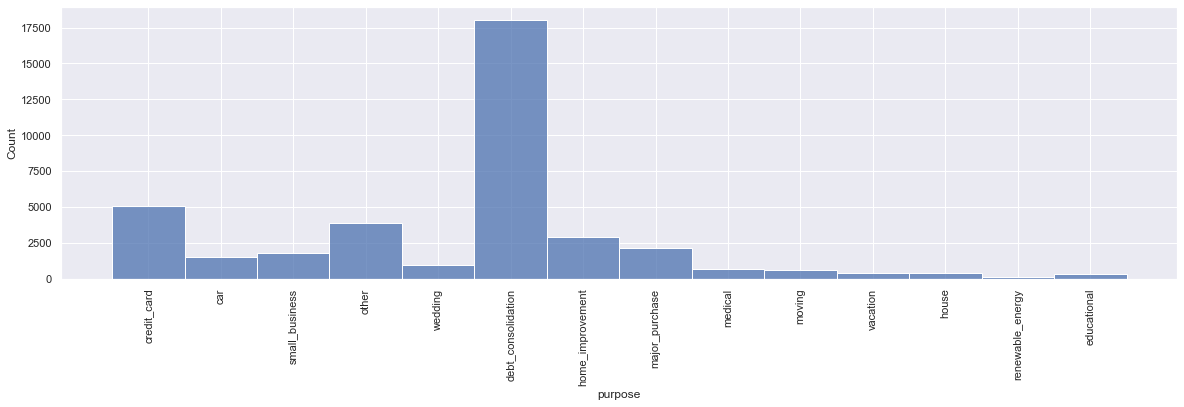

In [37]:
sns.set(rc={'figure.figsize':(20,5)})
univar("purpose")
pyplot.xticks(rotation=90)
pyplot.show() # observation: Most number of loans are taken for the purpose of debt consolidation followed by credit card

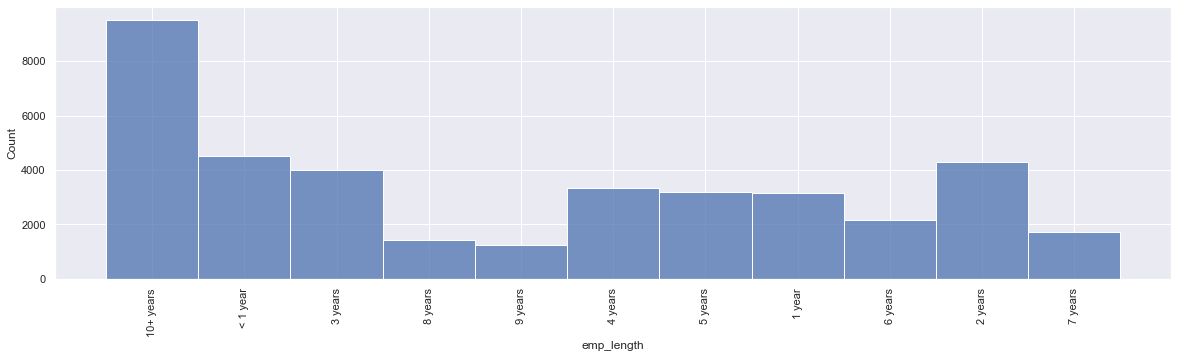

In [38]:
sns.set(rc={'figure.figsize':(20,5)})
univar("emp_length")
pyplot.xticks(rotation=90)
pyplot.show() # observation: Most number of loans are taken for the purpose of debt consolidation followed by credit card

### Distribution by issue dates and months

In [39]:
import datetime as dt
loan['issue_year'] = loan['issue_d'].dt.year.astype('str')
loan['issue_month'] = loan['issue_d'].dt.month
months = {1:'Jan',2:'Feb', 3:'Mar',4:'Apr',5:'May',6:'Jun',7:'Jul',8:'Aug',9:'Sep',10:'Oct',11:'Nov',12:'Dec'}
loan['issue_month'] = loan['issue_month'].apply(lambda x: months.get(x))

<AxesSubplot:xlabel='issue_year', ylabel='Count'>

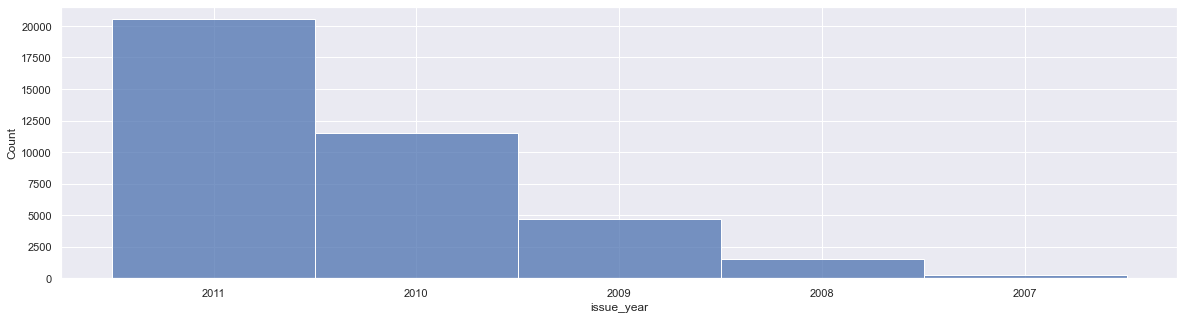

In [40]:
univar("issue_year") # observation: Portfolio credit growth has increased over the years

<AxesSubplot:xlabel='issue_month', ylabel='Count'>

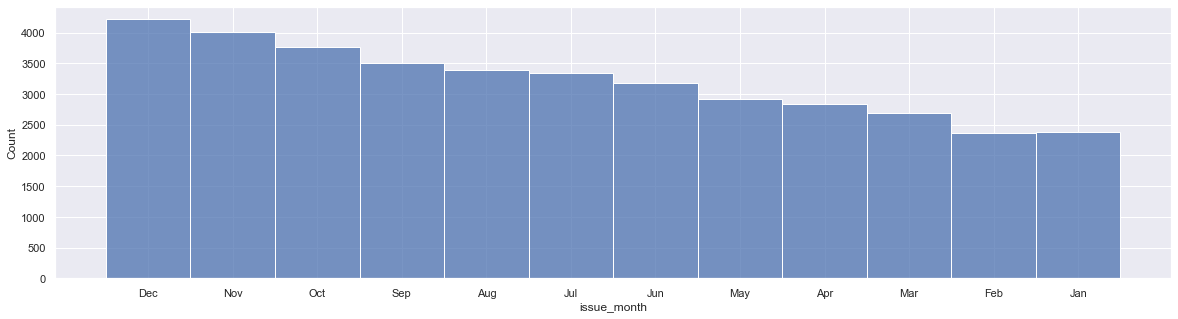

In [41]:
univar("issue_month") # Observation: Oct-Dec is the quarter with highest no. of loans issued

### Inference from Univariate analysis
The findings can be summarized as below based on the earlier listed objective:


1. *Distribution*:
* Defaults make approximarely 15% of the portfolio (closed loans,i.e. either fully paid or charged off)
* CA, FL and NY have the largest geographical concentration of loans




\
2. *Patterns*:
* Annual income is skewed. Its better to use dti ratio for segmented analysis which is more evenly distributed
* Similar to annual income, revolving balance is skewed. Revolving utilization rate is more evenly distributed
* Customer behaviour needs to be analyzed further in terms of accounts, revolving utilization rates, etc. 
* Oct-Dec (Quarter 4) of the year has the highest number of loans issues. 

<!-- The largest purpose of loans issues are debt consolidation, could there be any link here? Or could this be linked to year end holidays? We can find out more in bivariate analysis.
 -->

\
3. *Characterstics*:
* In terms of categorical variables, most loans are of 36 month term.
* Most loans are either A or B grade.
* Most borrowers do not have mortagage or own homes. Most loans are not verified and Most borrowers do not have a public record. 

## Takeaways from Univariate analysis

* Loan Amount, Funded loan amount and Funded loan amount by investors are mostly identical and hence only loan amount can be considered for further analysis
* Recovery related variables may be considered for analysis related to recommendations but not as drivers of default
* Outliers are present in annual income. Similarly installment is affected by the loan amount. Hence, dti will be considered to capture the information of income and debt-installments.
* Revolving utilization rate will be considered for further analysis, because of skewed distribution of revolving balance.

## Segmented Univariate

Based on the univariate analysis, let us see how the distribution varies when we compare each of the variables in terms of charged off vs fully paid. Before we do that, we need to create Buckets for some of the continuous variables.

In [42]:
def segplots(list,data = loan,svar = "loan_status", name = "number",title = "plot",long = False):
    '''
    this function creates sub-plots based on the variable and plot needed
    args: name is chosen based on the variable type: "number" for continuous variable and 
    "count" for categorical variable
    '''
    # if len(list) % 2 == 0: 
    #     n = (len(list)//2)
    # else:
    #     n = (len(list)//2) + 1
    n = len(list)
    fig, axes = pyplot.subplots(n, 3, figsize=(15, 5*n))        
    fig.suptitle(title)
    if name == "number":
              
        for i in range(len(list)):
            newvar = list[i] + "_bucket"
            data[newvar] = pd.cut(data[list[i]], bins=5, right=False)
            
            pyplot.subplot(n,1,i+1)
            sns.countplot(data= data,x = newvar, hue = svar) #.legend(bbox_to_anchor =(0.5, 1.15), ncol = 2)
            # gr.set_xticklabels(gr.get_xticklabels(),rotation = 30)
            # DF2.plot(x = newvar,kind = "barh", stacked = True).legend(bbox_to_anchor =(0.5, 1.15), ncol = 2)
            pyplot.title(list[i])
            pyplot.subplots_adjust(bottom=1, top=2)
            
    if name == "count":
        for i in range(len(list)):
            pyplot.subplot(n,1,i+1)
            sns.countplot(data = data, x = list[i], hue = svar)
            pyplot.title(list[i])


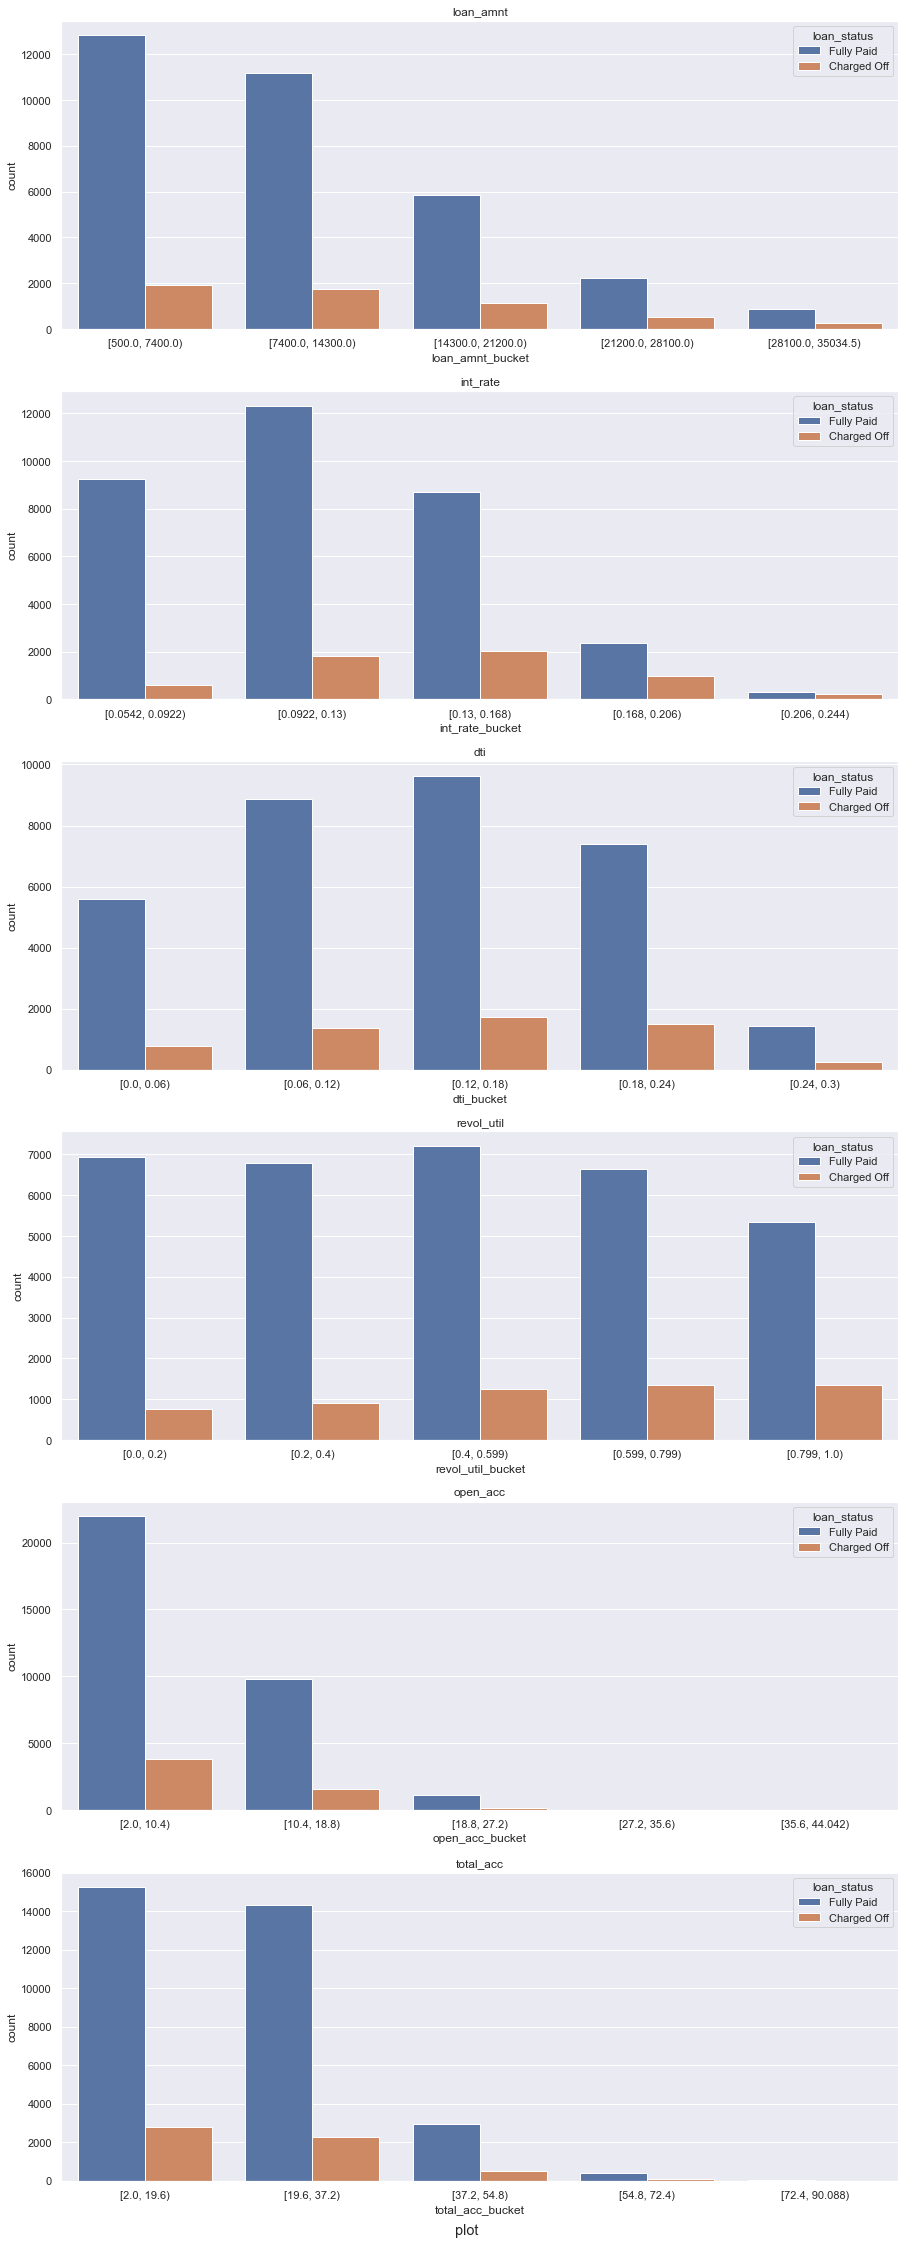

In [43]:
numeric2 = ['loan_amnt',"int_rate","dti","revol_util","open_acc","total_acc"]
segplots(numeric2)

## Observations:
* As number of loans are increasing or decreasing, the default number seem to be in proportion to the number of loans.
* In case of open and closed accounts, there does not seem to be much impact on the default number.

**Percentage defaults**:  Lets us  look at proprtion of fully paid and charged off loans for each variable in order to make more sense of the data.

In [44]:
def segment(Var,data = loan,svar = "loan_status", long = 0):
    
    if (data[Var].dtype == "int64") | (data[Var].dtype == "float64"):
        newvar = Var + "_bucket"
        data[newvar] = pd.cut(data[Var], bins=5, right=False)
        pivot = pd.pivot_table(data,index = svar,columns = newvar, aggfunc = "size")
        for x in pivot.columns.values:
            pivot[x] = pivot[x]/sum(pivot[x])
        pivot = pivot.T
        pivot.plot(kind = "barh", stacked = True).legend(bbox_to_anchor =(0.5, 1.15), ncol = 2)
        pyplot.show()
        
    elif (long == 0) & (loan[Var].dtype == "object"):
        piv = pd.pivot_table(data,index = svar,columns = Var, aggfunc = "size")
        for x in piv.columns.values:
            piv[x] = piv[x]/sum(piv[x])
        piv = piv.T
        piv.plot(kind = "barh", stacked = True).legend(bbox_to_anchor =(0.5, 1.15), ncol = 2)
        # pltdata = 
        pyplot.show()
    elif long ==1:
        piv = pd.pivot_table(data,index = svar,columns = Var, aggfunc = "size")
        for x in piv.columns.values:
            piv[x] = piv[x]/sum(piv[x])
        piv = piv.T
        piv.plot(kind = "bar", stacked = True).legend(bbox_to_anchor =(0.5, 1.15), ncol = 2)
        pyplot.show()
        

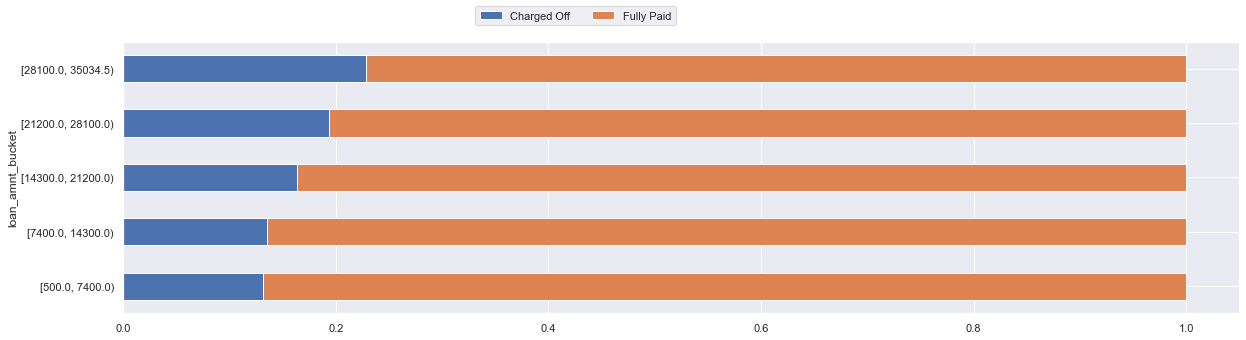

In [45]:
segment("loan_amnt") # observation: clear pattern seen -- defaults increase with loan amount

**Takeaway**: Default proportion seem to increase with loan amount, but this require further analysis in terms of atleast the purpose and term of the loan.

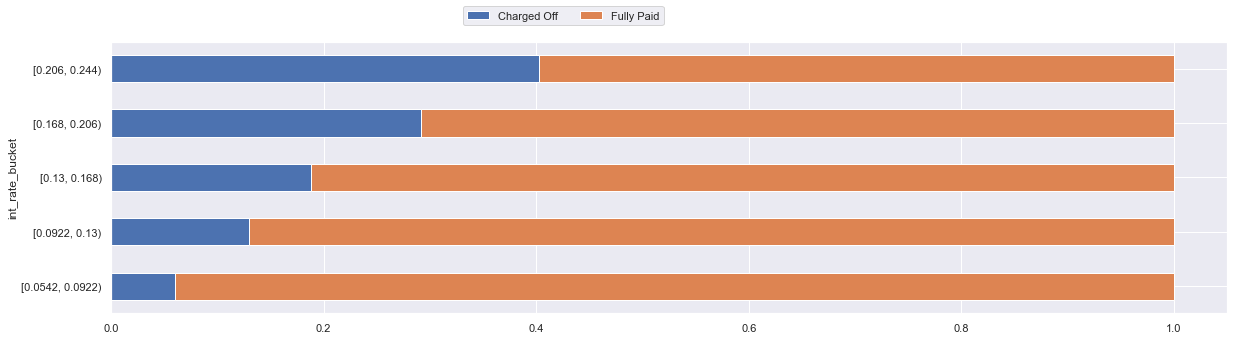

In [46]:
segment("int_rate") # observation: clear pattern seen defaults incnrease with interest rate

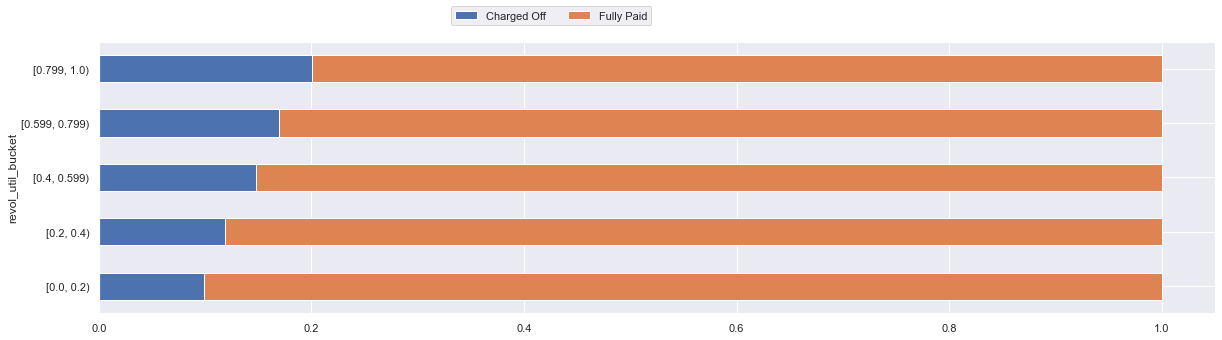

In [47]:
segment("revol_util") # observation: clear pattern seen - defaults increase with revolving utilization rate

**Takeaway**: revol_util can be noted as a candidate for one of the drivers

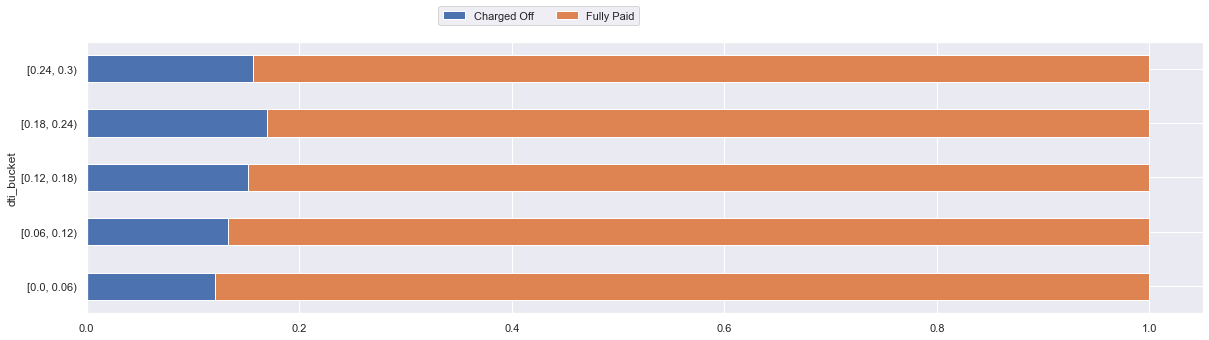

In [48]:
segment("dti") # observation -- defaults higher in dti ratio values higher than 0.18


**Takeaway**: dti can be noted as a candidate for one of the drivers

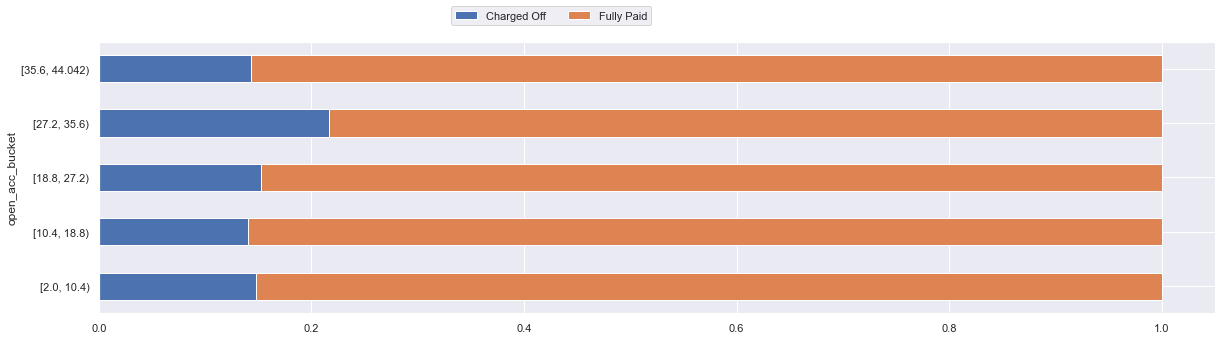

In [49]:
segment("open_acc") # observation -- no clear pattern seen

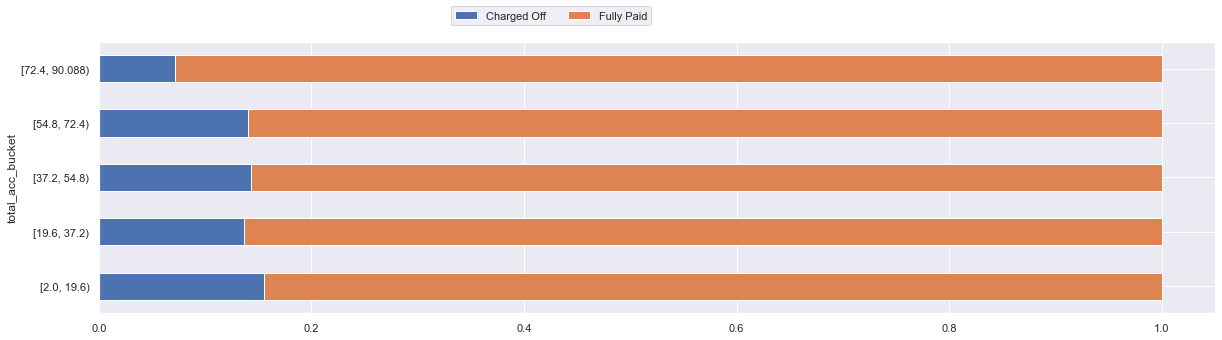

In [50]:
segment("total_acc") # observation -- no clear pattern seen

**Takeaway**: total and open accounts do not seem to stronly drive the default rate

In [51]:
loan.pub_rec = loan.pub_rec.astype(str)

In [52]:
loan.inq_last_6mths = loan.inq_last_6mths.astype(str)

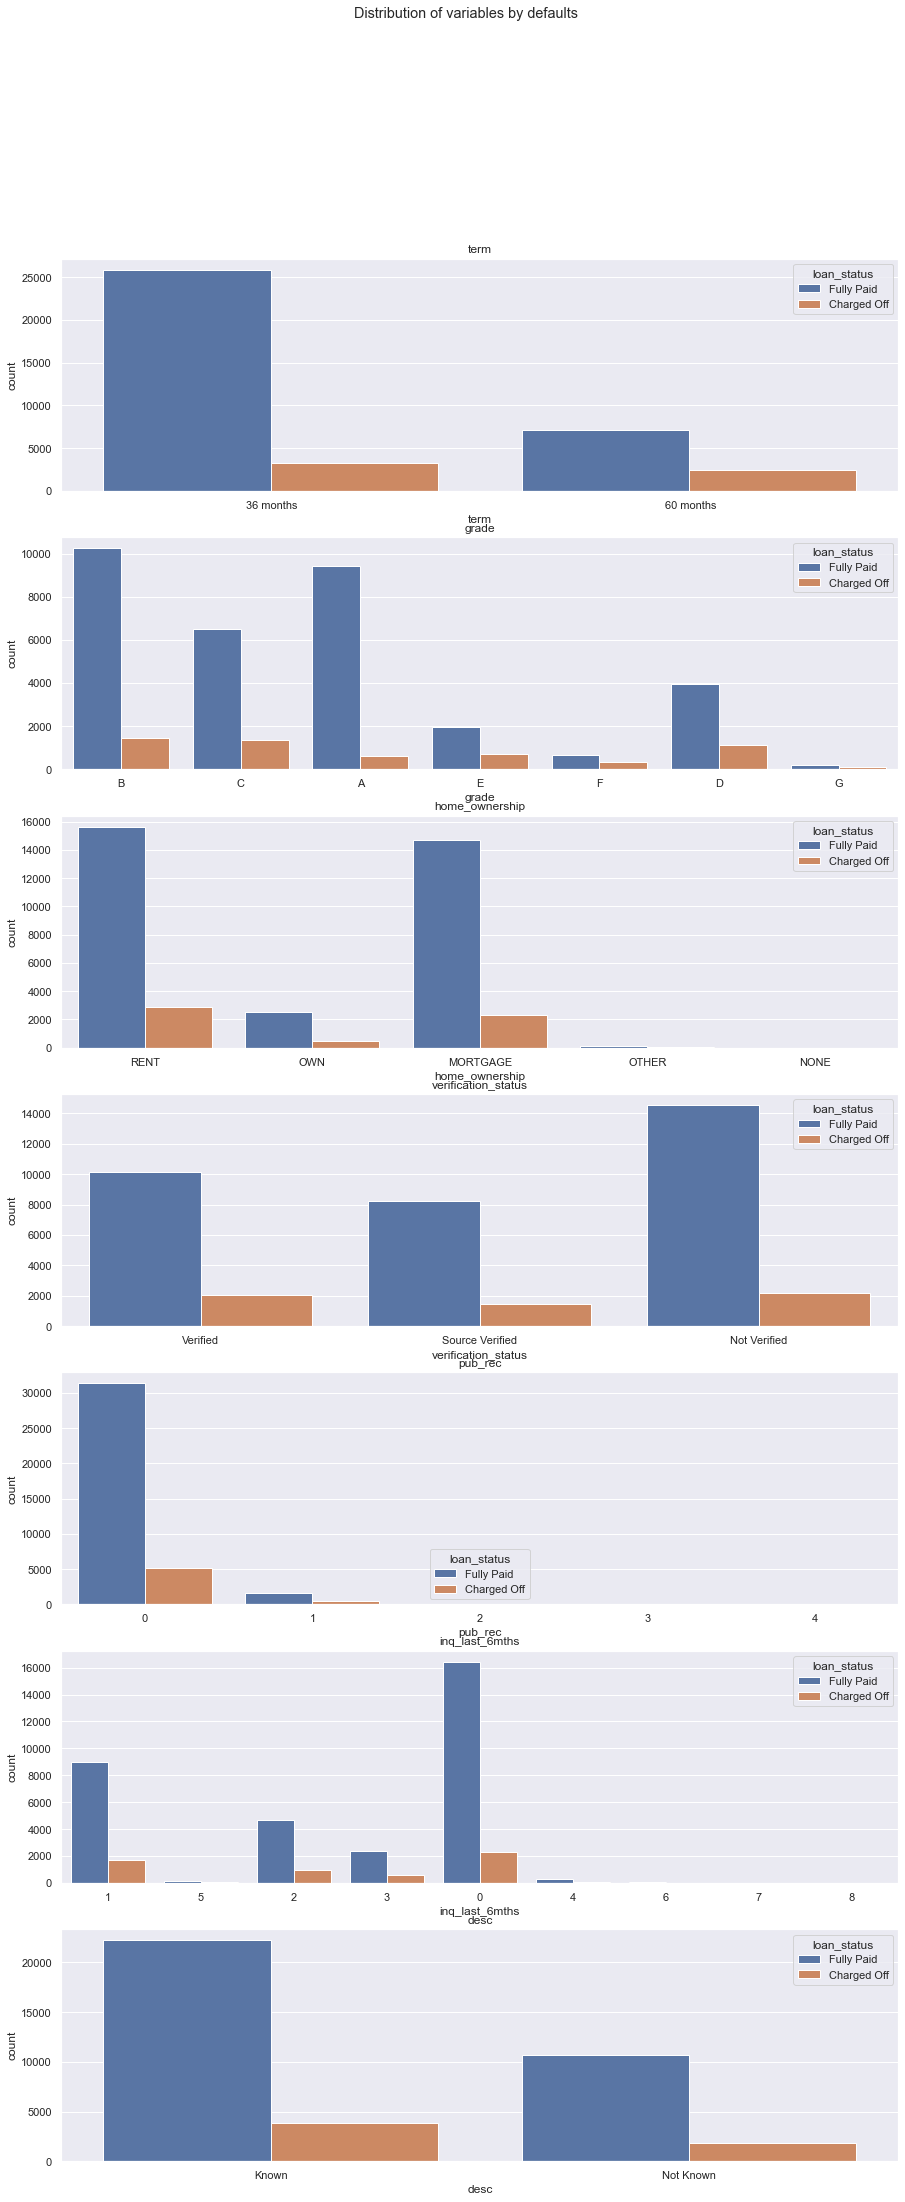

In [53]:
segplots(count, name = "count", title = "Distribution of variables by defaults")

## Obervations: 

* As the number of observations are differing with, it is difficult to judge through absolute numbers. Let us look at the proportion of defaults in each category.

**Percentage defaults**

term


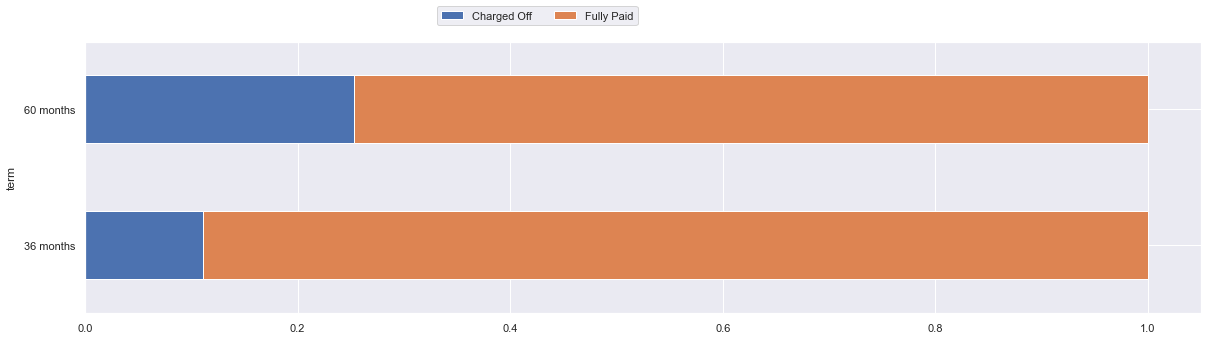

grade


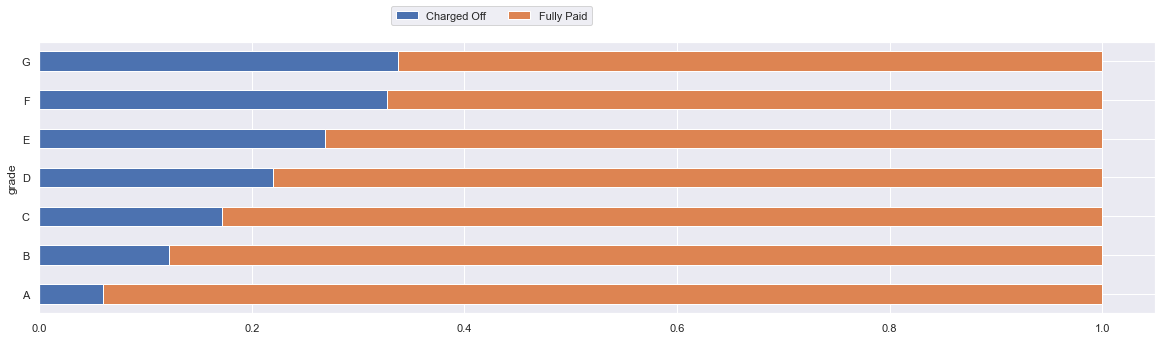

home_ownership


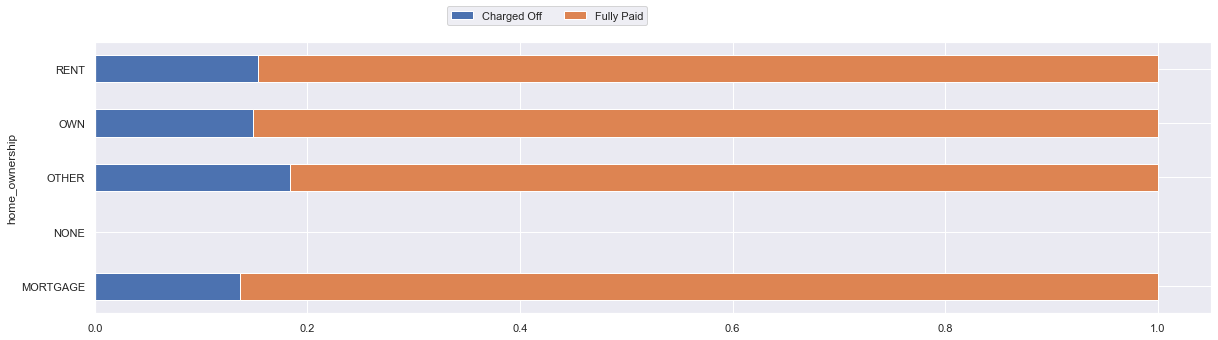

verification_status


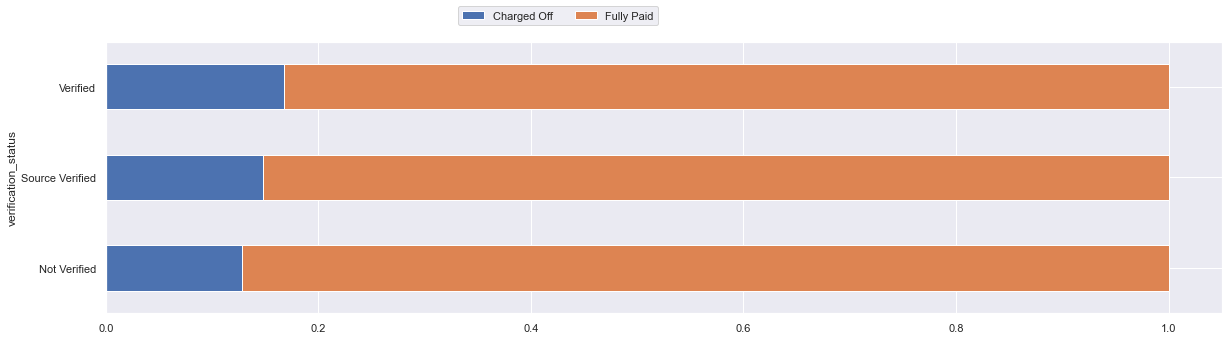

pub_rec


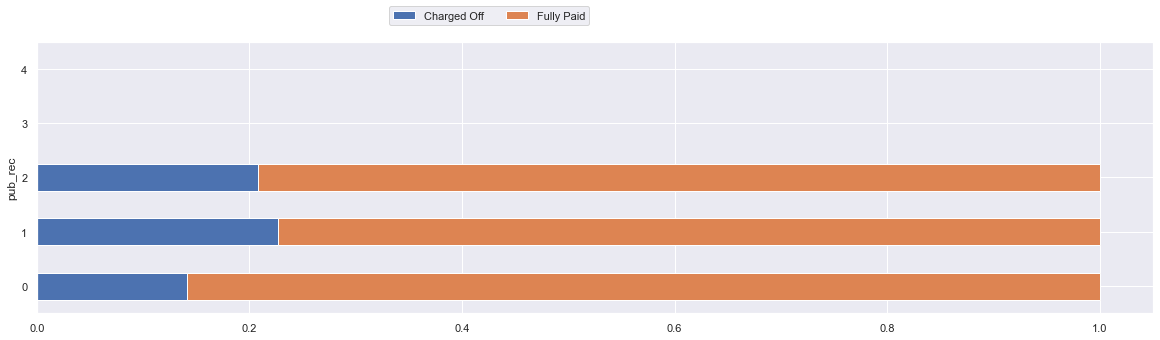

inq_last_6mths


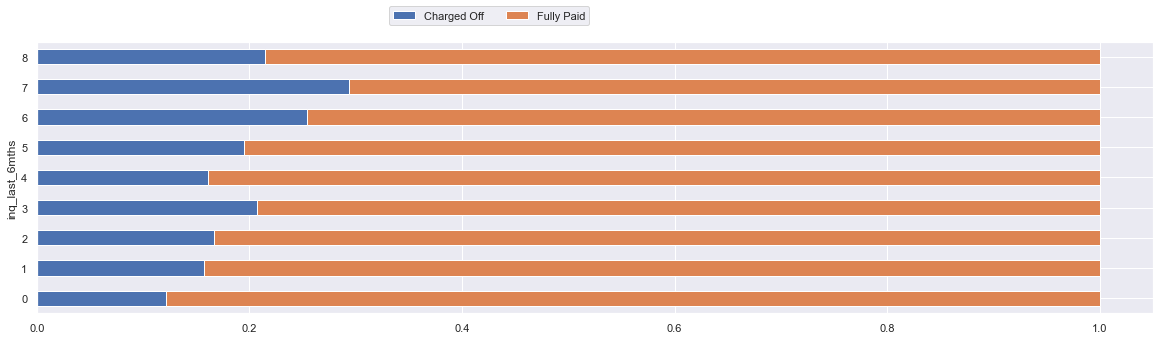

desc


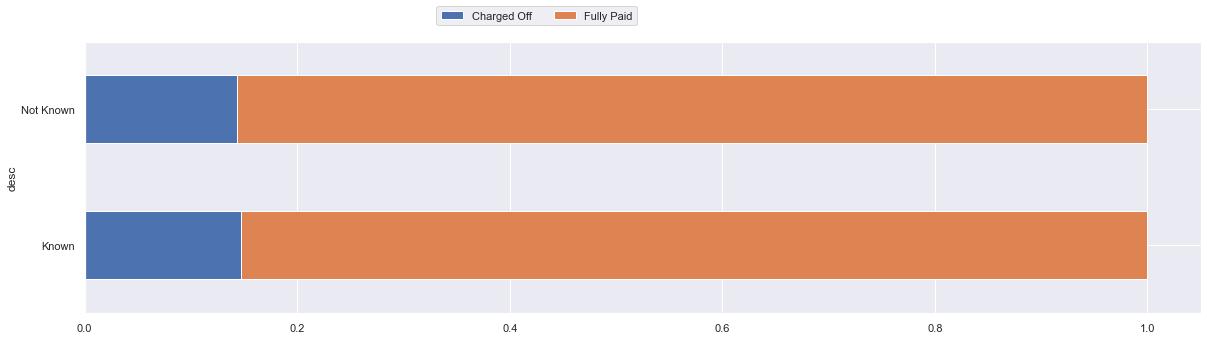

In [54]:
for i in range(len(count)):
    print(count[i])
    segment(count[i])

## Observations for each variable:

* **Term**: More proportion of defaults in loans with term of 60 months
* **Grade**: The result is as expected with defaults higher in riskier grades
* **Home ownership**: No particular pattern seen
* **Verification status**: Default proprtion is higher in loans with verified status, which is not as expected. But, it means that this variable may not have as much impact on default as expected
* **public record**: This is also as expected with borrowers with derogatory public records defaulting more often than borrowers with no derogatpry public record. We see that there are no borrowers with more than 2 public records.
* **loan.inq_last_6mths**: The result is as expected with borrowers more credit inquiries defaulting more.
* **desc**: Whether description has been provided by borrower or not has almost no impact on the default status.


**Date variables**

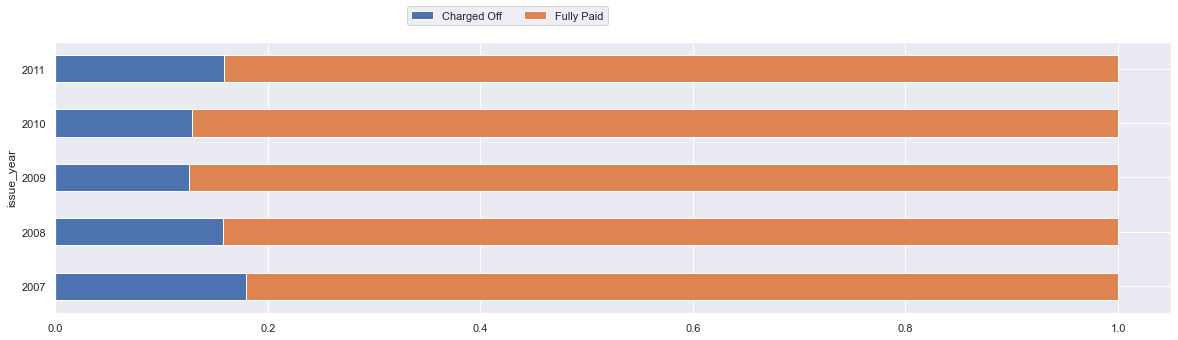

In [55]:
segment("issue_year") 

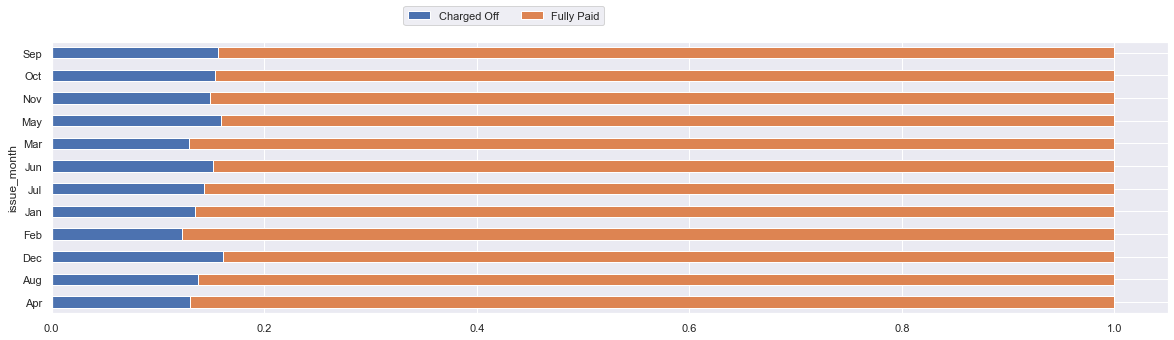

In [56]:
segment('issue_month')

## Observation:
* Month or year does not seem to have a major impact on the default, the number of defaults is in proportion to the number of loans issued for a given time period.

## Address state

<AxesSubplot:xlabel='addr_state', ylabel='count'>

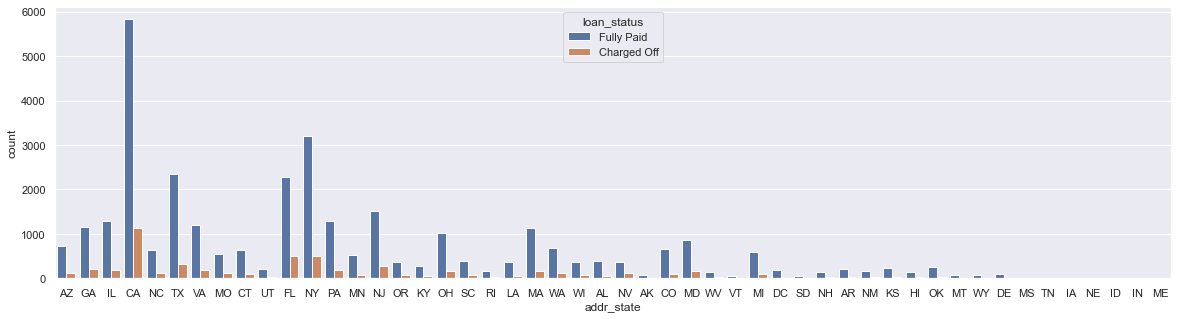

In [57]:
sns.countplot(data = loan,x = "addr_state",hue = "loan_status")

In [58]:
def longfun(Var,data = loan,svar = "loan_status"):
    piv = pd.pivot_table(loan,index = svar,columns = Var, aggfunc = "size")
    for x in piv.columns.values:
        piv[x] = piv[x]/sum(piv[x])
    piv = piv.T
    piv.plot(kind = "bar", stacked = True).legend(bbox_to_anchor =(0.5, 1.15), ncol = 2)
    pyplot.show()

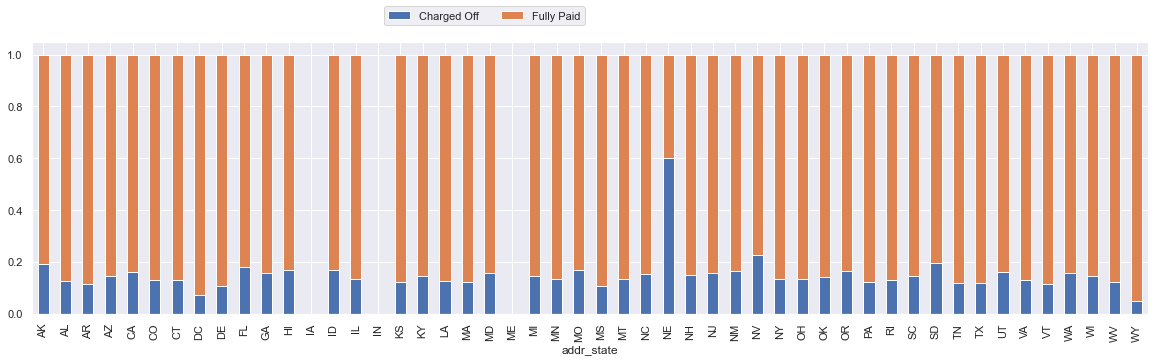

In [59]:
longfun('addr_state')

## Observations & Takeaways:

* **addr_state**: Nevada is an exception with very low number of loans issued, this can be ignored. In case of other states including the states with high number of loans CA, FL and NY, the proportion of defaults seem to be consisitent. Hence, geographic locations are **not** major drivers of default.

### Loan Purpose

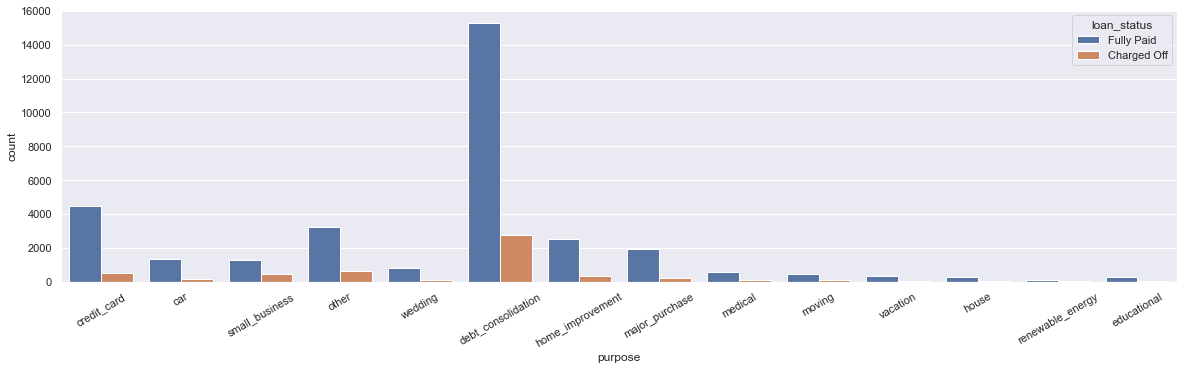

In [60]:
sn = sns.countplot(data = loan,x = "purpose",hue = "loan_status")
sn = sn.set_xticklabels(sn.get_xticklabels(),rotation = 30)

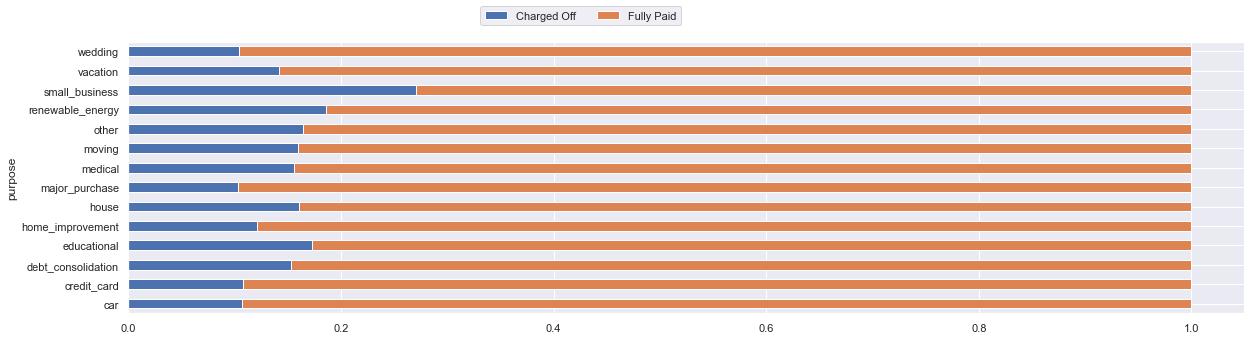

In [61]:
segment('purpose')

## Observation:
Analysis in terms of loan purpose is necessary to understand the portfolio and to suggest recommendations. 
* Most loans are issued for Debt consolidation and has  the highest number of defaults
* Small Business loans have the highest proportion of defaults
* Renewable energy loans are second, followed closely by educational, house and debt consolidation loans.

## Key Takeaways

Based on the univariate and univariate segmented analysis, loans with the following characterstics are identified to have higher number  of defaults:

* **DTI ratio**: Borrowers with higher DTI ratio have higher proportion of defaults
* **Revolving utilization rate**: Borrowers with higher revolving utilization rate have higher defaults
* **Derogatory Public records**: Borrowers with public records have higher proportion of defaults
* **Loan Amount**: Loans with higher amounts seems to have more defaults
* **Loan Purpose**: Debt consolidation have highest number of defaults and small business loans have highest proportion of defaults
* **Term**: Most loans are of 36 month but loans with 60 month tenor have higher proportion  of defaults compared to 36 months.

**Note**: 
1. Grade and Interest rates are linked to credit quality assessment and riskier loans default more hence pay higher interest rate. These are not drivers of default risk but a reflection of credit risk. Hence, these will not be considered for analysis.
2. Loan amount, Loan Purpose and Term need to segmented further to gain more insights

## Bivariate analysis

In this analysis, we compare the relation of two variables and how they are changing across the variable buckets/ distribution.

**Aim**: To ascertain if the variables identifed from univariate and univariate segmented analysis impact across loan types (purpose)


**Test**: We compare the central tendecies by plotting box plots across loan types to ascertain that the variable has same impact across loan types



1. **DTI**

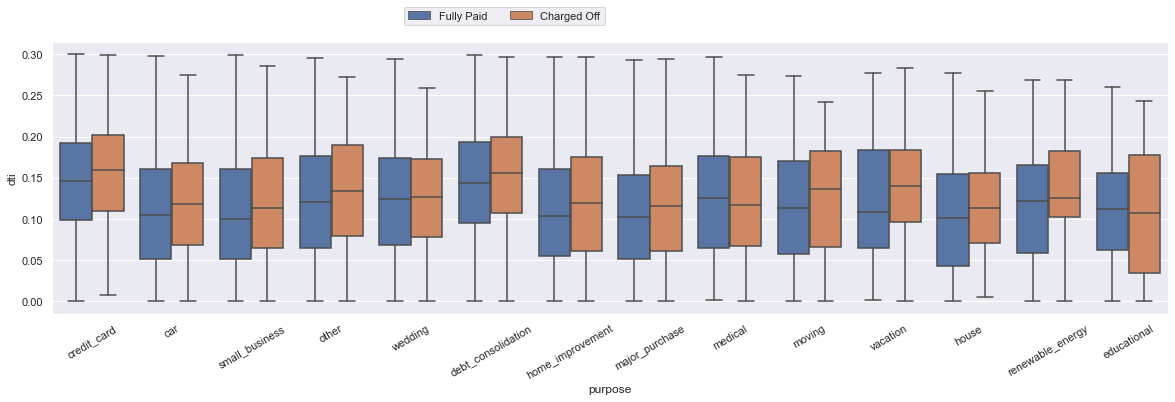

In [62]:
##Plot a box plot of Loan Purpose vs DTI segmented by Loan Status
box = sns.boxplot(loan['purpose'], loan.dti, hue = loan["loan_status"]).legend(bbox_to_anchor =(0.5, 1.15), ncol = 2)
pyplot.xticks(rotation=30)
pyplot.show()

**Result** : We see that DTI is consistently higher for charged off loans across loan types. Hence, we conclude that **DTI is a driving factor** of defaults. Only exceptions are medical and edicational but we know that usually students do not have high income and borrowers with loans with medical purposes can be subject to financial stress due to sudden loss of income and health issues.


2. **Revolving Utilization Rate**

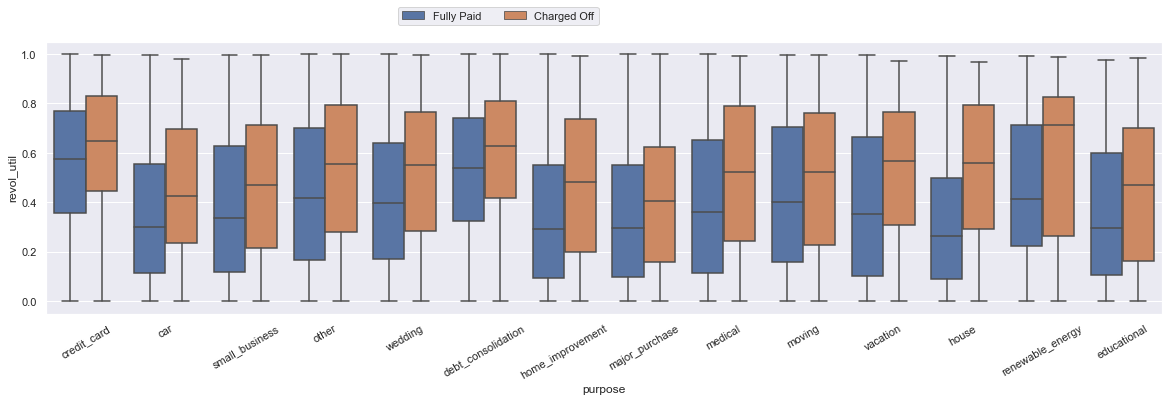

In [63]:
##Plot a box plot of Revolving Utilization rate vs purpose
box = sns.boxplot(loan['purpose'], loan["revol_util"], hue = loan["loan_status"]).legend(bbox_to_anchor =(0.5, 1.15), ncol = 2)
pyplot.xticks(rotation=30)
pyplot.show()

**Result**: We observe that high revolving utilization rate is a consistent feature of defauled loans across loan types. **Revolving utilization rate is a driving factor of defaults**

3. **Derogatory Public Records**

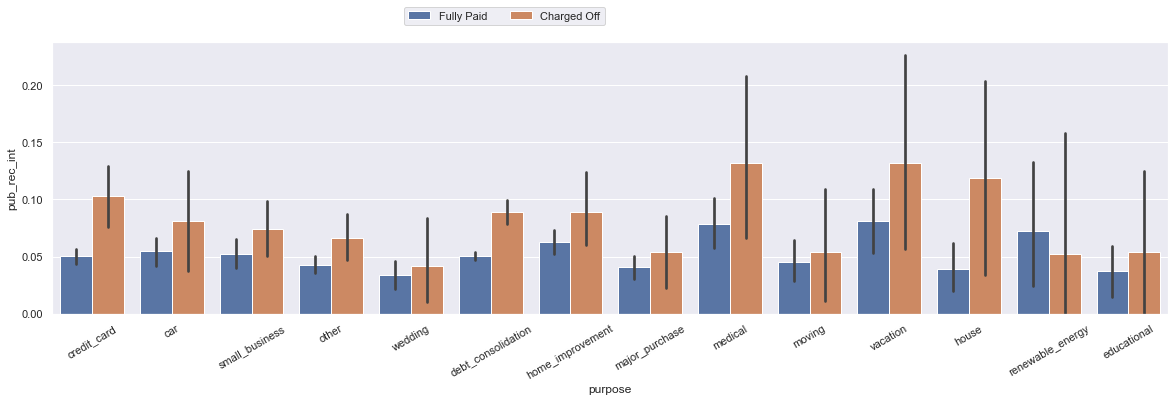

In [64]:

loan['pub_rec_int'] = loan['pub_rec'].astype(int)
sns.barplot(data=loan, x="purpose", y="pub_rec_int", estimator=np.mean,hue = "loan_status").legend(bbox_to_anchor =(0.5, 1.15), ncol = 2)
pyplot.xticks(rotation=30)
pyplot.show()

**Result**: We observe that average number of deragatory ratings is consistently higher for defaulted loans across loan types. Hence, **number of derogatory public records is seen as a driver of default risk**.

4. **Inquiries in the last 6 months**

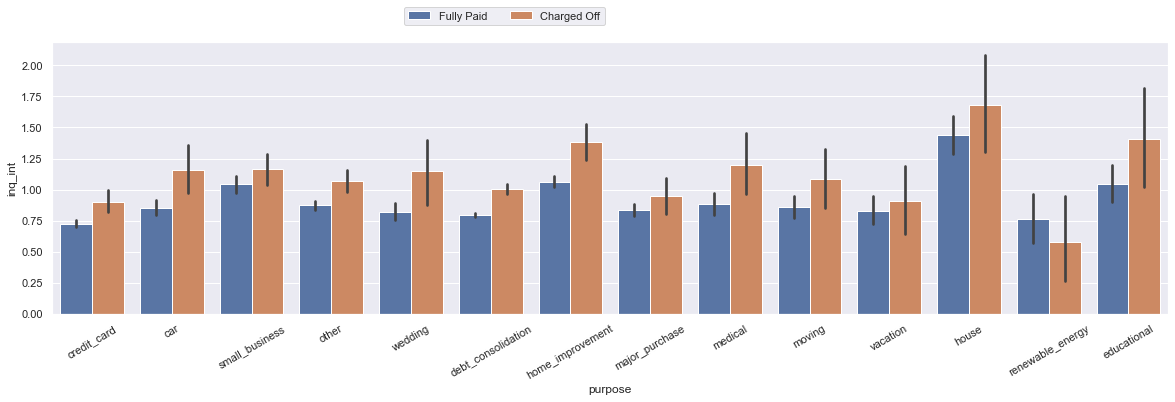

In [65]:
# Comparing across loan types
loan['inq_int'] = loan['inq_last_6mths'].astype(int)
sns.barplot(data=loan, x="purpose", y="inq_int", estimator=np.mean,hue = "loan_status").legend(bbox_to_anchor =(0.5, 1.15), ncol = 2)
pyplot.xticks(rotation=30)
pyplot.show()

**Result**: We observe that number of inquiries in last 6 months before default are higher on average across loan types. Hence, **number of inqueries in last 6 months** is one of the drivers of default. 

5. **Home Ownership** 

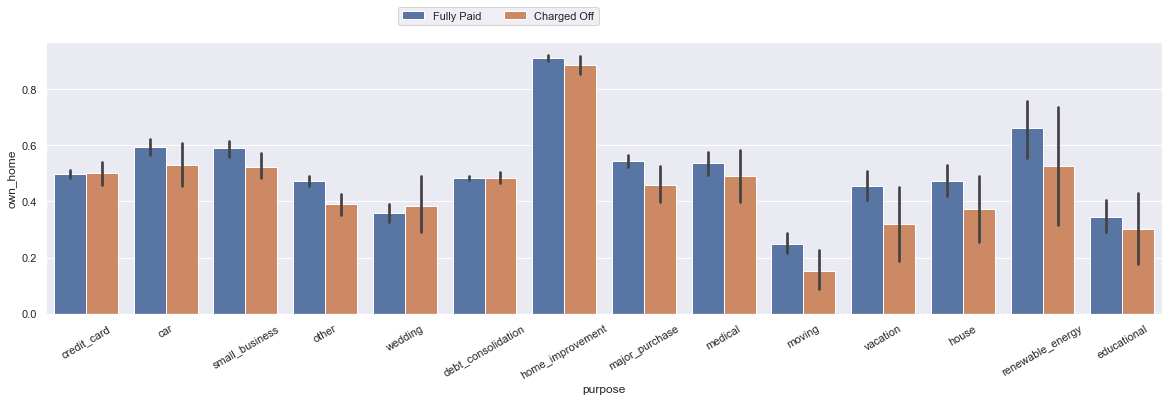

In [66]:
loan['own_home'] = loan['home_ownership'].apply(lambda x: 1 if x  in ['OWN','MORTGAGE'] else 0) # derived metric 1 -- home is owned/ mortgage ; 0- Rented or other
sns.barplot(data=loan, x="purpose", y="own_home", estimator=np.mean,hue = "loan_status").legend(bbox_to_anchor =(0.5, 1.15), ncol = 2)
pyplot.xticks(rotation=30)
pyplot.show()

**Result**: When home is owned, it is seen across most loan types, especially small business, renewable energy which have high proportion of default. Hence, we can say that **home ownership acts as an indicator of defaults**.

6. **open accounts**

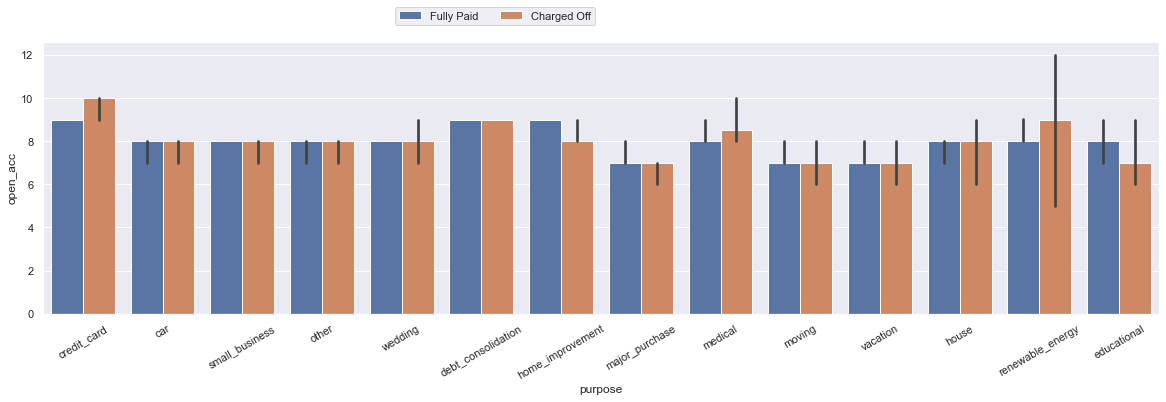

In [67]:
# loan['own_home'] = loan['home_ownership'].apply(lambda x: 1 if x  in ['OWN','MORTGAGE'] else 0)
sns.barplot(data=loan, x="purpose", y="open_acc", estimator=np.median,hue = "loan_status").legend(bbox_to_anchor =(0.5, 1.15), ncol = 2)
pyplot.xticks(rotation=30)
pyplot.show()

**Result**: No significant difference observed in number of open accounts compared for defaulted vs non-defaulted loans across loan types. Hence, number of open accounts is **not** considered as a driver of defaults.

## Conclusion: Drivers of default

Based on the abaove analysis, when an application is recieved, it is recommended to check for the 5 driving factors listed: DTi, Revolving Utilization rate, public records, inquiries and home ownership.

## Issues & Recommendations

1. **Issue**: Higher loan amounts have higher number of defaults

**Observation**: Based on the below plot, it can be seen that high loan amounts are usually associated with risky grades.

**Recommendation**: Lending club should apply a cap on the loan amounts based on rating grades. Higher loans should not be funded for risky customers.

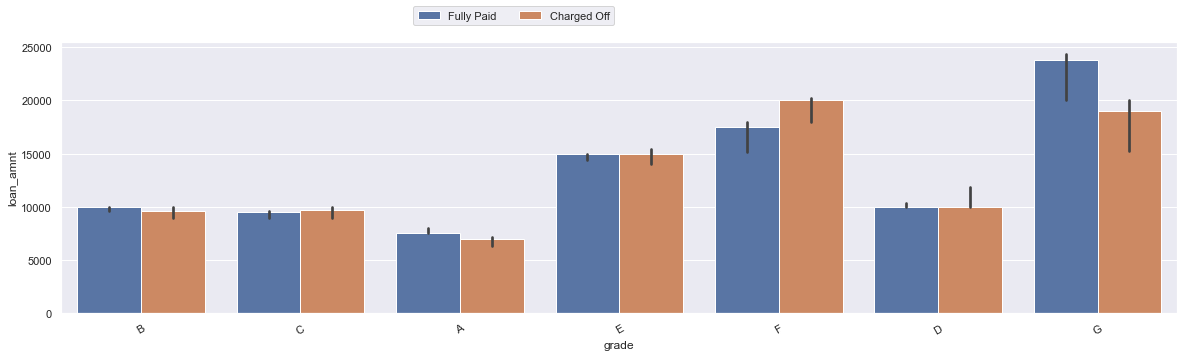

In [68]:
sns.barplot(data=loan, x="grade", y="loan_amnt",estimator = np.median,hue = "loan_status").legend(bbox_to_anchor =(0.5, 1.15), ncol = 2)
pyplot.xticks(rotation=30)
pyplot.show()

2. **Issue**: Pricing interest rates -  The identified drivers of default need to be considered for pricing interest rates

**Observation**: Based on the plots below, the median interest rates are almost the same across the dti buckets and number of inquiries. 

**Recommnedation**: Pricing can be improved for loans with risky attributes such as high DTI and other identified driving factors.

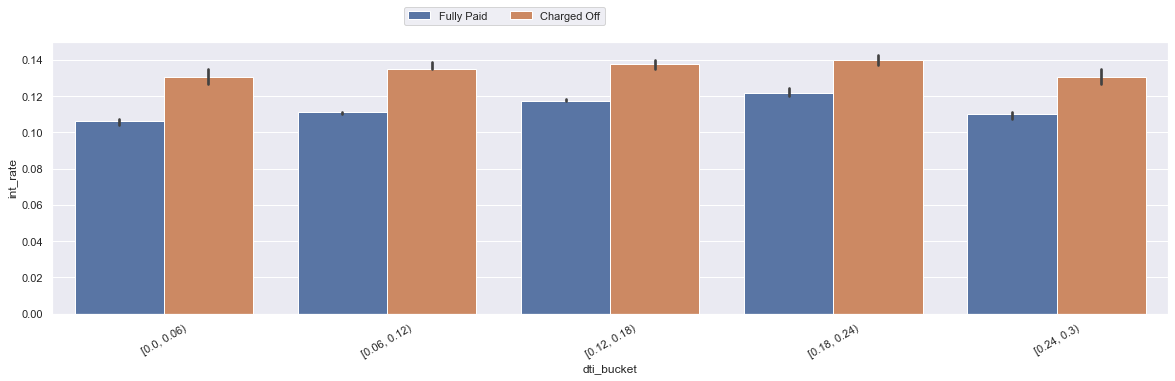

In [69]:
# Comparing across loan types
# loan['inq_int'] = loan['inq_last_6mths'].astype(int)
sns.barplot(data=loan, x="dti_bucket", y="int_rate", estimator=np.median,hue = "loan_status").legend(bbox_to_anchor =(0.5, 1.15), ncol = 2)
pyplot.xticks(rotation=30)
pyplot.show()

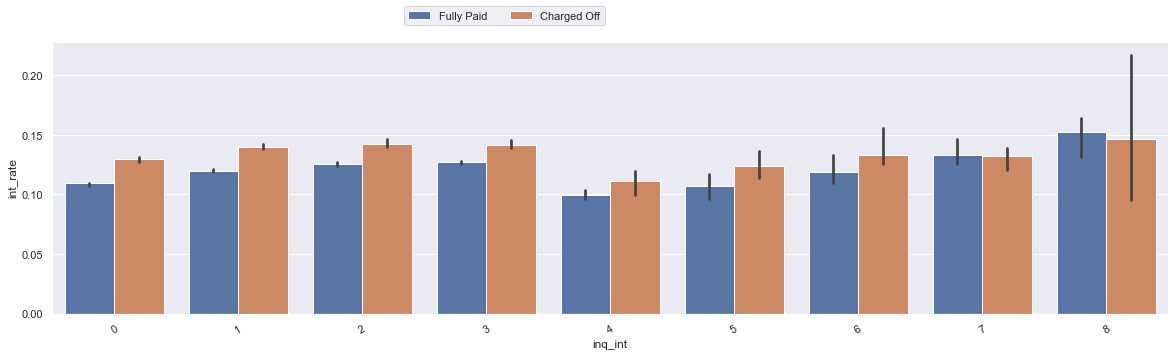

In [70]:
# Comparing across loan types
# loan['inq_int'] = loan['inq_last_6mths'].astype(int)
sns.barplot(data=loan, x="inq_int", y="int_rate", estimator=np.median,hue = "loan_status").legend(bbox_to_anchor =(0.5, 1.15), ncol = 2)
pyplot.xticks(rotation=30)
pyplot.show()